# 1.1 Radial velocity analysis of WASP-12b 

### Universidad de La Laguna Exo & Exo 2023-2024 exercise 1

Author: [Hannu Parviainen](mailto:hannu@iac.es)<br>
Last updated: 28.4.2024

This first exercise teaches you how to estimate the minimum planetary mass from radial velocity measurements using [Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference).


## (The absolute basics of) radial velocities

A planet orbiting a star causes the star to [move around the star-planet barycentre](https://exoplanets.nasa.gov/alien-worlds/ways-to-find-a-planet/#/1). This leads to a periodic change in the star's position and velocity,
and the radial component of the star's velocity can be measured using [doppler spectroscopy](https://en.wikipedia.org/wiki/Doppler_spectroscopy). Radial velocity (RV) measurements are used to search for unknown planets and to estimate the minimum masses and orbital periods of known planets.

![Doppler shift vs time](Doppler_Shift_vs_Time.svg "Doppler shift vs time")


A planet with a mass $M_\mathrm{p}$ orbiting a star with a mass $M_\star$ with an orbital period $P$ leads to a periodic signal with a semi-amplitude of

$$
K = \left(\frac{2\pi G}{P}\right)^{1/3} \frac{M_\mathrm{p} \sin i}{(M_\star + M_\mathrm{p})^{2/3}} \frac{1}{(1-e^2)^{1/2}},
$$

where $G$ is the [gravitational constant](https://en.wikipedia.org/wiki/Gravitational_constant), $e$ is the [orbital eccentricity](https://en.wikipedia.org/wiki/Orbital_eccentricity), and $i$ is the [orbital inclination](https://en.wikipedia.org/wiki/Orbital_inclination). After we estimate $P$, $K$, and $M_\star$ we can solve for the minimum planetary mass $M_\mathrm{p} \sin i$. The orbital period and RV semi-amplitude can be estimated directly from the RV signal, but the stellar mass needs to be estimated using other means.


## (The absolute basics of) Bayesian parameter estimation

Measuring the RV semi-amplitude and the orbital period from RV measurements is a *parameter estimation* problem: we assume we have an adequate model to describe the observations, and we want to infer the model parameters with their uncertainties.

We take a [*Bayesian*](http://en.wikipedia.org/wiki/Bayesian_probability) approach to the parameter estimation, where we want to estimate the [*posterior probability*](http://en.wikipedia.org/wiki/Posterior_probability) for the model parameters given their [*prior probabilities*](http://en.wikipedia.org/wiki/Prior_probability) and a set of observations. The posterior probability density given a parameter vector $\theta$ and observational data $D$ is described by the [*Bayes' theorem*](http://en.wikipedia.org/wiki/Bayes%27_theorem) as

$$
P(\theta|D) = \frac{P(\theta) P(D|\theta)}{P(D)}, \qquad P(D|\theta) = \prod P(D_i|\theta),
$$

where $P(\theta)$ is the prior, $P(D|\theta)$ is the [*likelihood*](http://en.wikipedia.org/wiki/Likelihood_function) for the data, and $P(D)$ is a [*normalising factor*](http://en.wikipedia.org/wiki/Marginal_likelihood) we don't need to bother with during MCMC-based parameter estimation. 

The likelihood is a product of individual observation probabilities, and has the unfortunate tendency to end up being either very small or very big. This causes computational headaches, and it is better to work with log probabilities instead, so that

$$
\log P(\theta|D) = \log P(\theta) + \log P(D|\theta),  \qquad \log P(D|\theta) = \sum \log P(D_i|\theta)
$$

where we have omitted the $P(D)$ term from the posterior density.

Now we still need to decide our likelihood density. If we can assume normally distributed white noise--that is, the errors in the observations are independent and identically distributed--we end up with a log likelihood function

$$
 \log P(D|\theta) = -N\log(\sigma) -\frac{N\log 2\pi}{2} - \sum_{i=0}^N \frac{(o_i-m_i)^2}{2\sigma^2},
$$

where $N$ is the number of datapoints, $\sigma$ is the white noise standard deviation, $o$ is the observed data, and $m$ is the model. 

This should be enough for these exercies, but you can find more information from [A primer about Bayesian statistics](https://ui.adsabs.harvard.edu/link_gateway/2018haex.bookE.149P/EPRINT_PDF) and the references therein.

## Initialisation

In [2]:
%matplotlib inline

In [3]:
import sys
print(sys.executable)

/Users/carlota/anaconda3/envs/exoplanets/bin/python


In [100]:
import pandas as pd
import astropy.units as u

from matplotlib.pyplot import subplots, setp, rc, Rectangle
from numpy import argmax, median, arctan2, pi, mean
from astropy.table import Table
from astropy.timeseries import LombScargle #way of finding periodicity from time series data
from corner import corner

from pytransit.lpf.rvlpf import RVLPF

rc('figure', figsize=(13,4))

## 1.1 Read in the RV data 

The radial velocity measurements consist of mid-observation times, radial velocity values, and radial velocity measurement uncertainties (also called as 'errors'). We use the data from [Yee et al. (2019)](https://iopscience.iop.org/article/10.3847/2041-8213/ab5c16). The data is stored as a CDS table that can be read directly using `astropy.table.Table`.

In [45]:
rv_data = Table.read('data/wasp_12b_yee_2019.dat', format='ascii.cds')

It's important to understand what sort of data we're dealing with, so we begin by displaying the table header and the five first rows.

In [6]:
rv_data[:5]  

BJD,RVel,e_RVel
d,m / s,m / s
float64,float64,float64
2455521.959432,-136.635,2.534
2455543.089922,5.728,2.919
2455545.983884,-162.39,2.822
2455559.906718,141.616,2.345
2455559.917563,115.818,2.727


It's also useful to visualise directly what we're working with, so we next plot the radial velocity data and its uncertainties as a function of time.

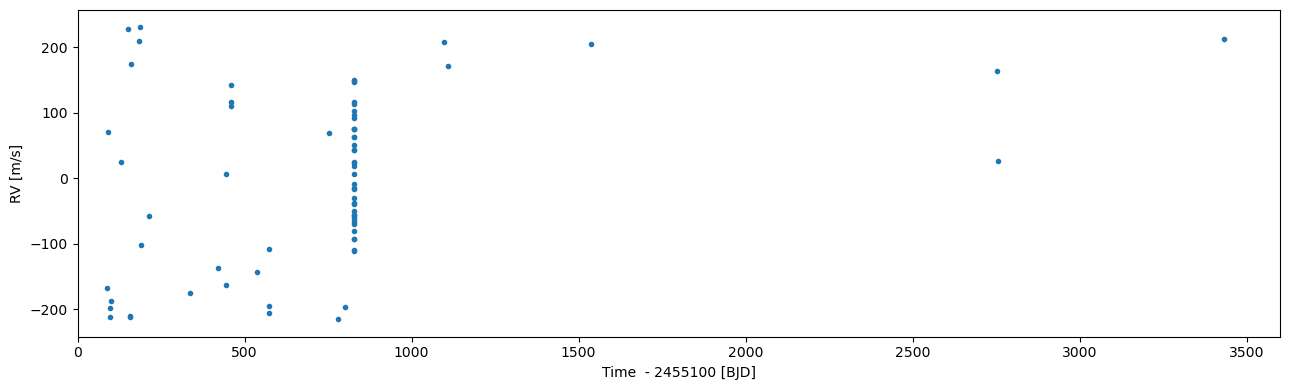

In [5]:
fig, ax = subplots()
ax.errorbar(rv_data['BJD'] - 2455100, rv_data['RVel'], rv_data['e_RVel'], fmt='.')
setp(ax, xlabel='Time  - 2455100 [BJD]', ylabel='RV [m/s]', xlim=(0, 3600))
fig.tight_layout()

### <span style="color:darkblue">Questions and exercises:</span>

1. Try to describe the logic behind the time sampling of the RV observations.

-  <span style="color:darkgreen"> The fact that there is a time scale where there is no data of radial velocity can be explained with two approaches: First, the system was simply not observed in those times or the data has not been published yet. The other possible explanation is that during the observations there was something in front of the object of study, or in less probable scenarios, there was a huge mass of dust created in those times which opaque the observations. 

2. Plot below the RV observations as a function of time focusing on the densely-sampled time-span.

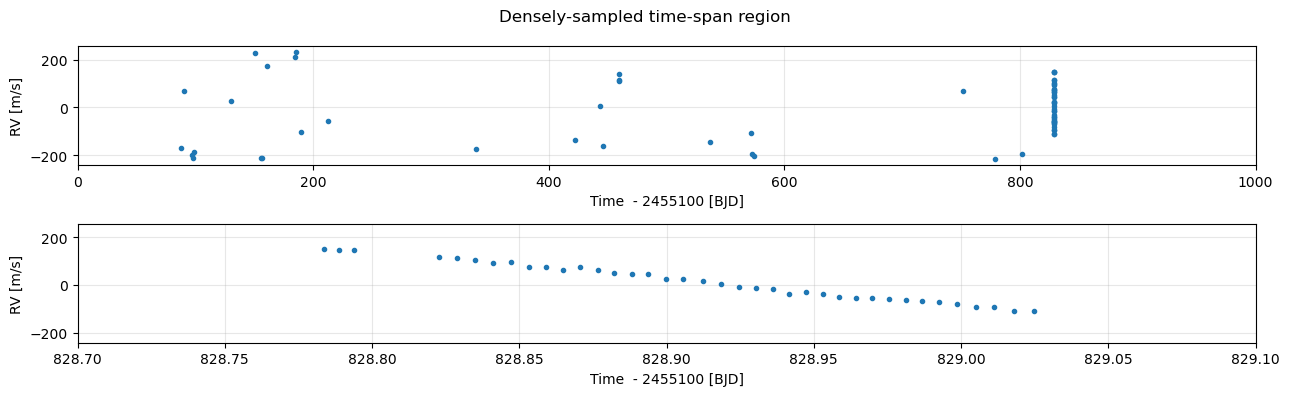

In [46]:
fig, ax = subplots(2,1)
fig.suptitle('Densely-sampled time-span region')
ax[0].errorbar(rv_data['BJD'] - 2455100, rv_data['RVel'], rv_data['e_RVel'], fmt='.')
setp(ax[0], xlabel='Time  - 2455100 [BJD]', ylabel='RV [m/s]', xlim=(0, 1000))

ax[1].errorbar(rv_data['BJD'] - 2455100, rv_data['RVel'], rv_data['e_RVel'], fmt='.')
setp(ax[1], xlabel='Time  - 2455100 [BJD]', ylabel='RV [m/s]', xlim=(828.7, 829.1))

[ax[i].grid(alpha=.3) for i in range(2)]
fig.tight_layout()

## 1.2 Search for a radial velocity signal

First, we use a Lomb-Scargle periodigram to search for a sinusoidial radial velocity signal from the RV measurements. This is simple to do with `astropy.timeseries.LombScargle` class that is initialised with the mid-measurement times and the RV observations.

In [7]:
ls = LombScargle(rv_data['BJD'], rv_data['RVel'])

Next, we use the `LombScargle.autopower` to calculate the periodogram. We restrict the search to $0.5 < P < 5$ days.

In [8]:
frequency, power = ls.autopower(minimum_frequency=1/(5*u.d), maximum_frequency=2/u.d)
period = 1/frequency

In [9]:
best_period = period[argmax(power)]
best_period

<Quantity 1.09144998 d>

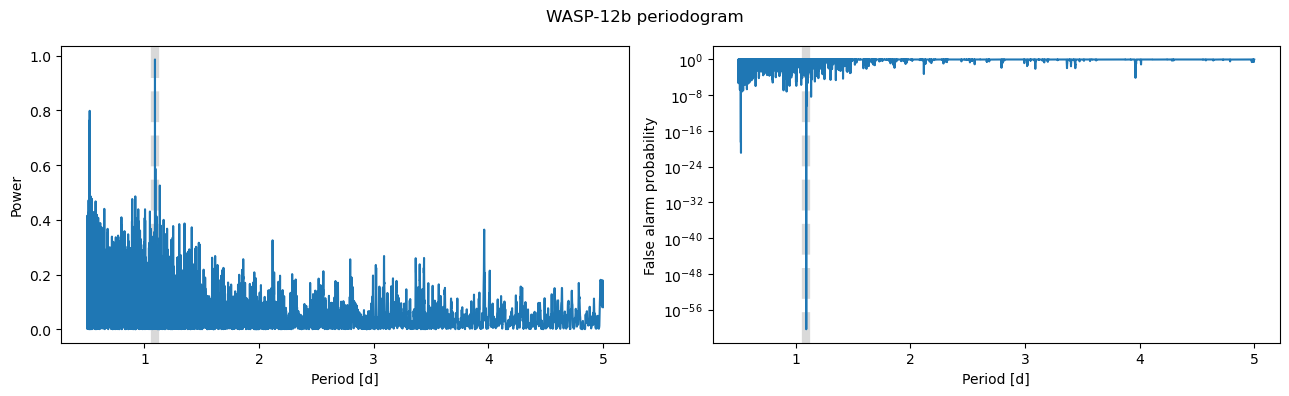

In [9]:
fig, axs = subplots(1, 2, figsize=(13,4))
axs[0].plot(period, power)
axs[1].semilogy(period, ls.false_alarm_probability(power)) 
    #False alarm probability needed because we are working with periodogram (how likely the observed signal is due to random noise)
[ax.axvline(best_period.value, c='k', ls='--', zorder=-1, lw=6, alpha=0.15) for ax in axs]
setp(axs, xlabel='Period [d]')
setp(axs[0], ylabel='Power')
setp(axs[1], ylabel='False alarm probability')
fig.suptitle('WASP-12b periodogram')
fig.tight_layout()

Let's see what happens when we plot the RV values folded over the best period.

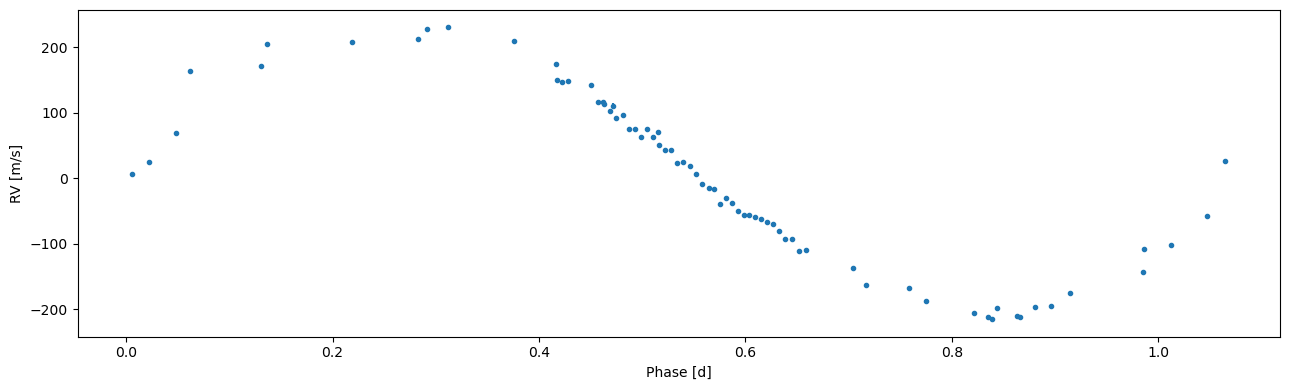

In [10]:
fig, ax = subplots()
ax.errorbar(rv_data['BJD'] % best_period.value, rv_data['RVel'], rv_data['e_RVel'], fmt='.')
setp(ax, xlabel='Phase [d]', ylabel='RV [m/s]')
fig.tight_layout()

## 1.3 Radial velocity modelling

Now when we know the RV data contains a suspicious signal, we can model it to study what sort of an object is causing it. The two most important parameters we're interested are the orbital period and radial velocity semiamplitude (K). The RV semiamplitude will give us the lower limit of the object's mass ($m\sin i$) which will then tell us whether we're dealing with a planet or something else.

### Initialise the model

In [13]:
lpf = RVLPF('WASP-12b', 1, rv_data['BJD'], rv_data['RVel'], rv_data['e_RVel'])

In [14]:
lpf.ps #Plotting the parameters .ps

[  0 |G| tc_1           N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p_1            N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| secw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   3 |G| sesw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   4 |G| rv_shift_0     N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   5 |G| rv_err_0       U(a = 0.0, b = 1.0)                      [    -inf ..      inf],
   6 |G| rv_k_1         U(a = 0.0, b = 1.0)                      [    0.00 ..      inf],
   7 |G| rv_slope       N(μ = 0.0, σ = 1.0)                      [    -inf ..      inf]]

The parameters are

- `tc_1`: transit center [BJD]
- `p_1`: orbital period [d]
- `secw_1`: $\sqrt{e} \cos\omega$, where $e$ is the eccentricity and $\omega$ the argument of periastron
- `sesw_1`: $\sqrt{e} \sin\omega$
- `rv_shift_0`: systemic velocity [m/s]
- `rv_err_0`: additional white noise [m/s]
- `rv_k_1` RV semiamplitude [m/s]
- `rv_slope`: additional linear slope

### Set the parameter priors

Bayesian inference requires a prior probability distribution for each of our model parameters. These "priors" can be based on previous studies, theoretical expectations, or more generally in our beliefs on what values the parameters can take.

In this case we use two priors: a normal prior (NP) and a uniform prior (UP). The normal prior models our prior belief using a normal distribution with a known mean and standard deviation, while the uniform prior says that the paramer can take any value between a minimum and maximum boundary.

In [15]:
# The idea is to assume some statementes to make a first model
lpf.set_prior('tc_1', 'NP', 2458480.65, 0.02) # Normal prior (distribution) (mean, sigma)
lpf.set_prior('p_1', 'NP', 1.09, 0.1)
lpf.set_prior('rv_shift_0', 'NP', 0.0, 10)
lpf.set_prior('rv_err_0', 'UP', 0.0, 30.0) # Uniform prior (min, max)
lpf.set_prior('rv_k_1', 'UP', 0.0, 300)

In [16]:
lpf.ps

[  0 |G| tc_1           N(μ = 2458480.65, σ = 0.02)              [    -inf ..      inf],
   1 |G| p_1            N(μ = 1.09, σ = 0.1)                     [    0.00 ..      inf],
   2 |G| secw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   3 |G| sesw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   4 |G| rv_shift_0     N(μ = 0.0, σ = 10.0)                     [    -inf ..      inf],
   5 |G| rv_err_0       U(a = 0.0, b = 30.0)                     [    -inf ..      inf],
   6 |G| rv_k_1         U(a = 0.0, b = 300)                      [    0.00 ..      inf],
   7 |G| rv_slope       N(μ = 0.0, σ = 1.0)                      [    -inf ..      inf]]

### Fit the model to the data

Global optimisation:   0%|          | 0/2000 [00:00<?, ?it/s]

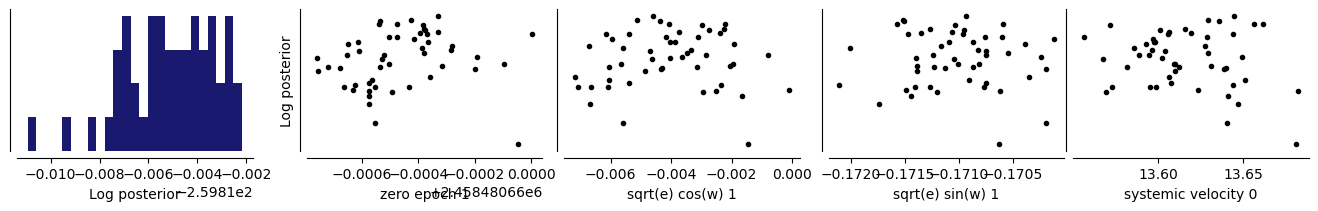

In [17]:
lpf.optimize_global(2000)

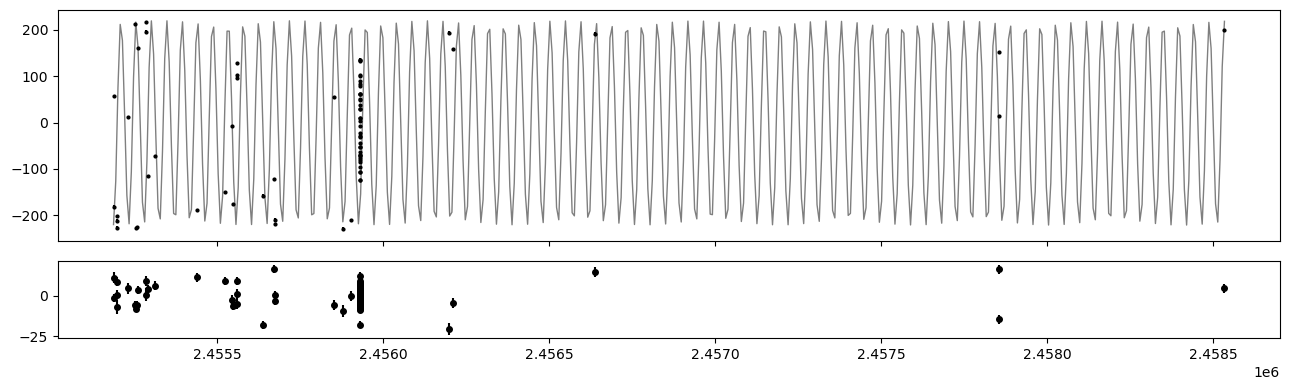

In [19]:
lpf.plot_rv_vs_time();

/Users/carlota/anaconda3/envs/exoplanets/lib/python3.11/site-packages/pytransit/lpf/rvlpf.py:363: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].errorbar(phase[m], rvs[m], self._rvea[m], fmt='o', marker=markers[iid],


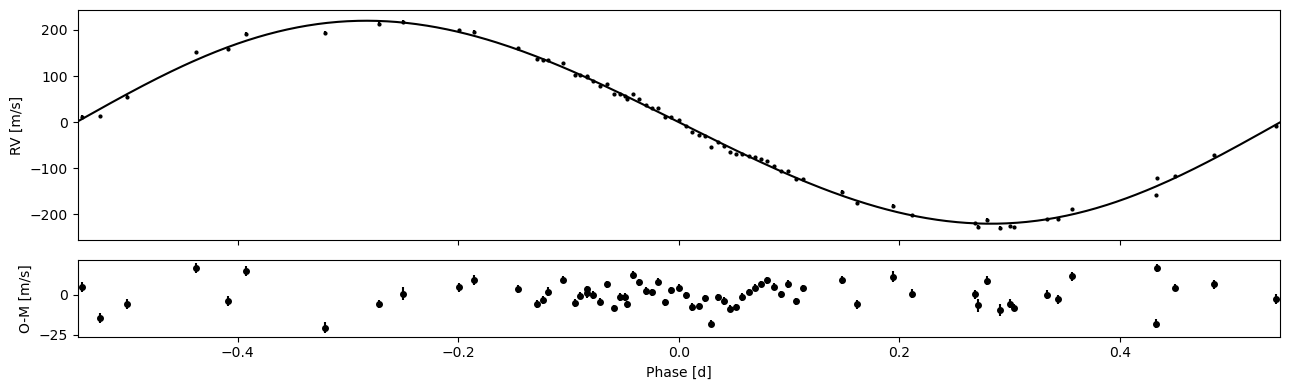

In [20]:
lpf.plot_rv_vs_phase(0);

### Estimate the parameter posterior distributions using MCMC

We estimate the [posterior probability distributions](https://en.wikipedia.org/wiki/Posterior_probability) of our model parameters using [Markov Chain Monte Carlo sampling](https://twiecki.io/blog/2015/11/10/mcmc-sampling). The sampling can be done using the `RVLPF.sample_mcmc` method after a global optimisation run has been finished. The `sample_mcmc` method uses the [*emcee*](https://emcee.readthedocs.io/en/stable) sampler under the hood.

We give `RVLPF.sample_mcmc` the number of MCMC steps to take (`niter`), a thinning factor (`thin`), and a number of repeats (`repeats`). This makes the sampler run first one round of `niter` steps, restarts the sampler from the last step of the previous run, and run again `niter` steps. This is the same as running the sampler for `2 x niter` and keeping only the second half of the steps. The first half is treated as a [warm-up period](https://stats.stackexchange.com/questions/88819/mcmc-methods-burning-samples) for the sampler and discarded. In general, the sampler is run `repeats x niter` steps in total, and only the last `niter` steps are retained.

The thinning factor tells the sampler to store only every $n$th step. In our case, we're storing only every 10th step. Thinning is a way to try to store only statistically independent samples, but is [not really necessary](https://besjournals.onlinelibrary.wiley.com/doi/pdf/10.1111/j.2041-210X.2011.00131.x). However, we'll do it to keep the number of samples low (there's no point in storing a large number of dependent samples either).

In [21]:
lpf.sample_mcmc(niter=2000, thin=10, repeats=2)

MCMC sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Run 1/2:   0%|          | 0/2000 [00:00<?, ?it/s]

Run 2/2:   0%|          | 0/2000 [00:00<?, ?it/s]

The *emcee* sampler uses an ensemble of MCMC chains to sample the posterior. This means that we have many chains running in parallel. We can plot the traces of each chain to see how the chain population behaves in time.

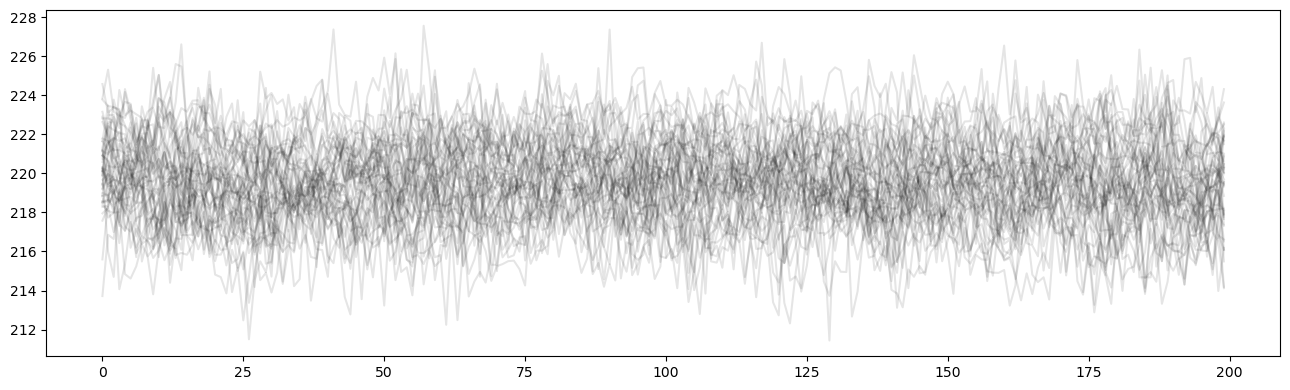

In [22]:
lpf.plot_mcmc_chains(6);

### Plot the model posterior

/Users/carlota/anaconda3/envs/exoplanets/lib/python3.11/site-packages/pytransit/lpf/rvlpf.py:285: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].errorbar(self._timea[m] + self._tref, rvs[m], self._rvea[m], fmt='o', marker=markers[iid],


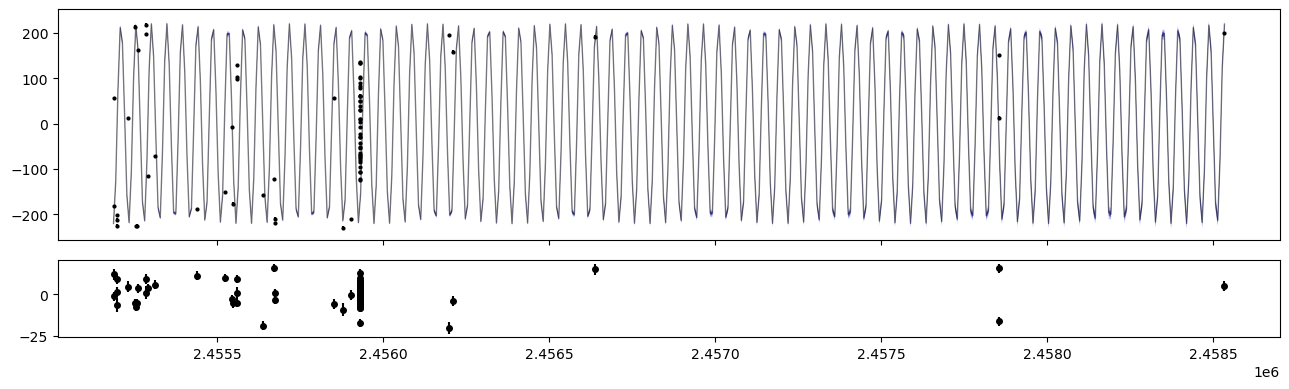

In [23]:
lpf.plot_rv_vs_time('mcmc');

/Users/carlota/anaconda3/envs/exoplanets/lib/python3.11/site-packages/pytransit/lpf/rvlpf.py:363: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].errorbar(phase[m], rvs[m], self._rvea[m], fmt='o', marker=markers[iid],


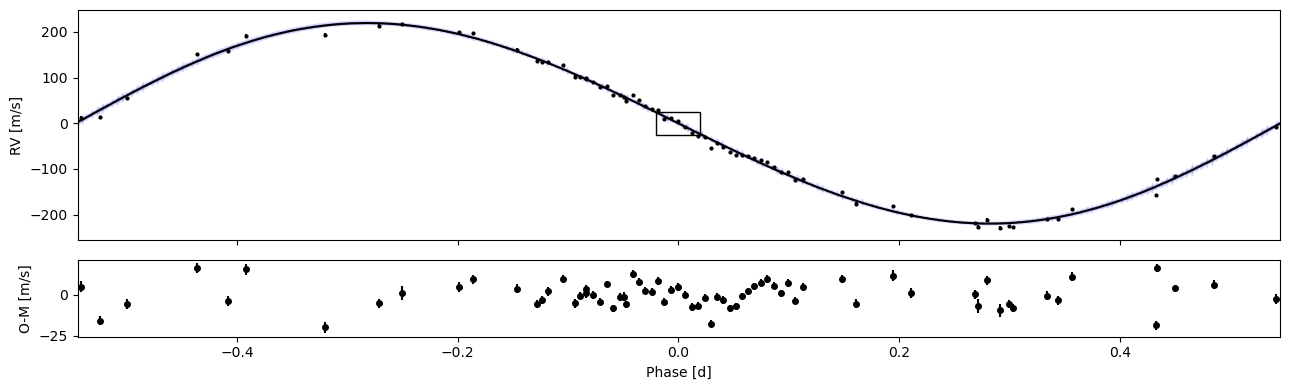

In [24]:
fig = lpf.plot_rv_vs_phase(0, 'mcmc')
fig.axes[0].add_patch(Rectangle((-.02, -25), 0.04, 50, fill=False));

When we zoom a little bit, we can see that we're now actually plotting the probability density of the model. The black line corresponds to the median of the model posterior, and the two shades to the 68% and 95% central posterior limits.

/Users/carlota/anaconda3/envs/exoplanets/lib/python3.11/site-packages/pytransit/lpf/rvlpf.py:363: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].errorbar(phase[m], rvs[m], self._rvea[m], fmt='o', marker=markers[iid],


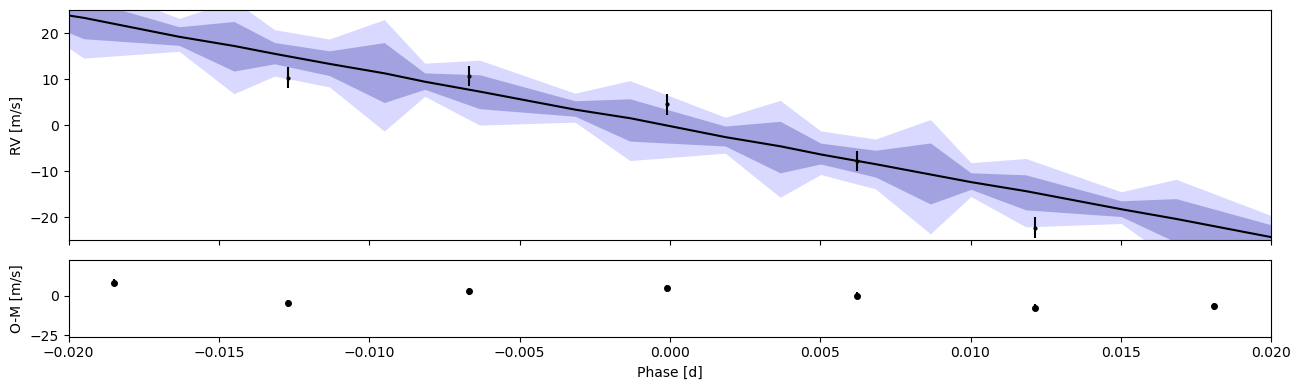

In [25]:
fig = lpf.plot_rv_vs_phase(0, 'mcmc')
setp(fig.axes[0], xlim=(-0.02, 0.02), ylim=(-25,25));

### Plot the parameter posteriors

In [27]:
df = lpf.posterior_samples()
df

,tc_1,p_1,secw_1,sesw_1,rv_shift_0,rv_err_0,rv_k_1,rv_slope
0,2.458481e+06,1.091421,-0.057162,-0.150212,13.725431,7.691952,218.827855,0.000938
1,2.458481e+06,1.091424,-0.011089,-0.147220,12.084302,6.078149,217.739504,0.003133
2,2.458481e+06,1.091424,-0.014791,-0.151340,12.281482,6.301077,217.988026,0.002422
3,2.458481e+06,1.091424,-0.013213,-0.151078,12.302355,6.337637,218.022013,0.002408
4,2.458481e+06,1.091420,0.035088,-0.154559,12.601206,6.045741,219.321031,0.000256
...,...,...,...,...,...,...,...,...
9995,2.458481e+06,1.091421,0.037549,-0.169557,12.928751,7.050977,217.340678,0.002452
9996,2.458481e+06,1.091422,0.035103,-0.176293,12.699519,7.541229,218.051786,0.001173
9997,2.458481e+06,1.091422,0.027852,-0.171997,13.082865,7.385482,218.090328,0.000779
9998,2.458481e+06,1.091421,0.052359,-0.171875,13.602748,7.261401,218.167367,0.004071


In [48]:
K = median(df.rv_k_1)
K

219.62055206617356

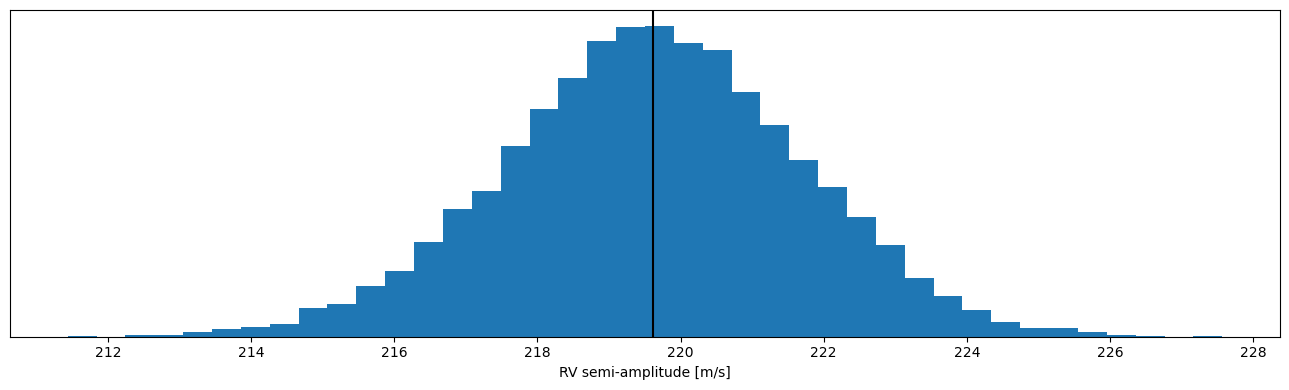

In [28]:
fig, ax = subplots()
ax.hist(df.rv_k_1, bins=40)
ax.axvline(median(df.rv_k_1), c='k')
setp(ax, xlabel='RV semi-amplitude [m/s]', yticks=[])
fig.tight_layout()

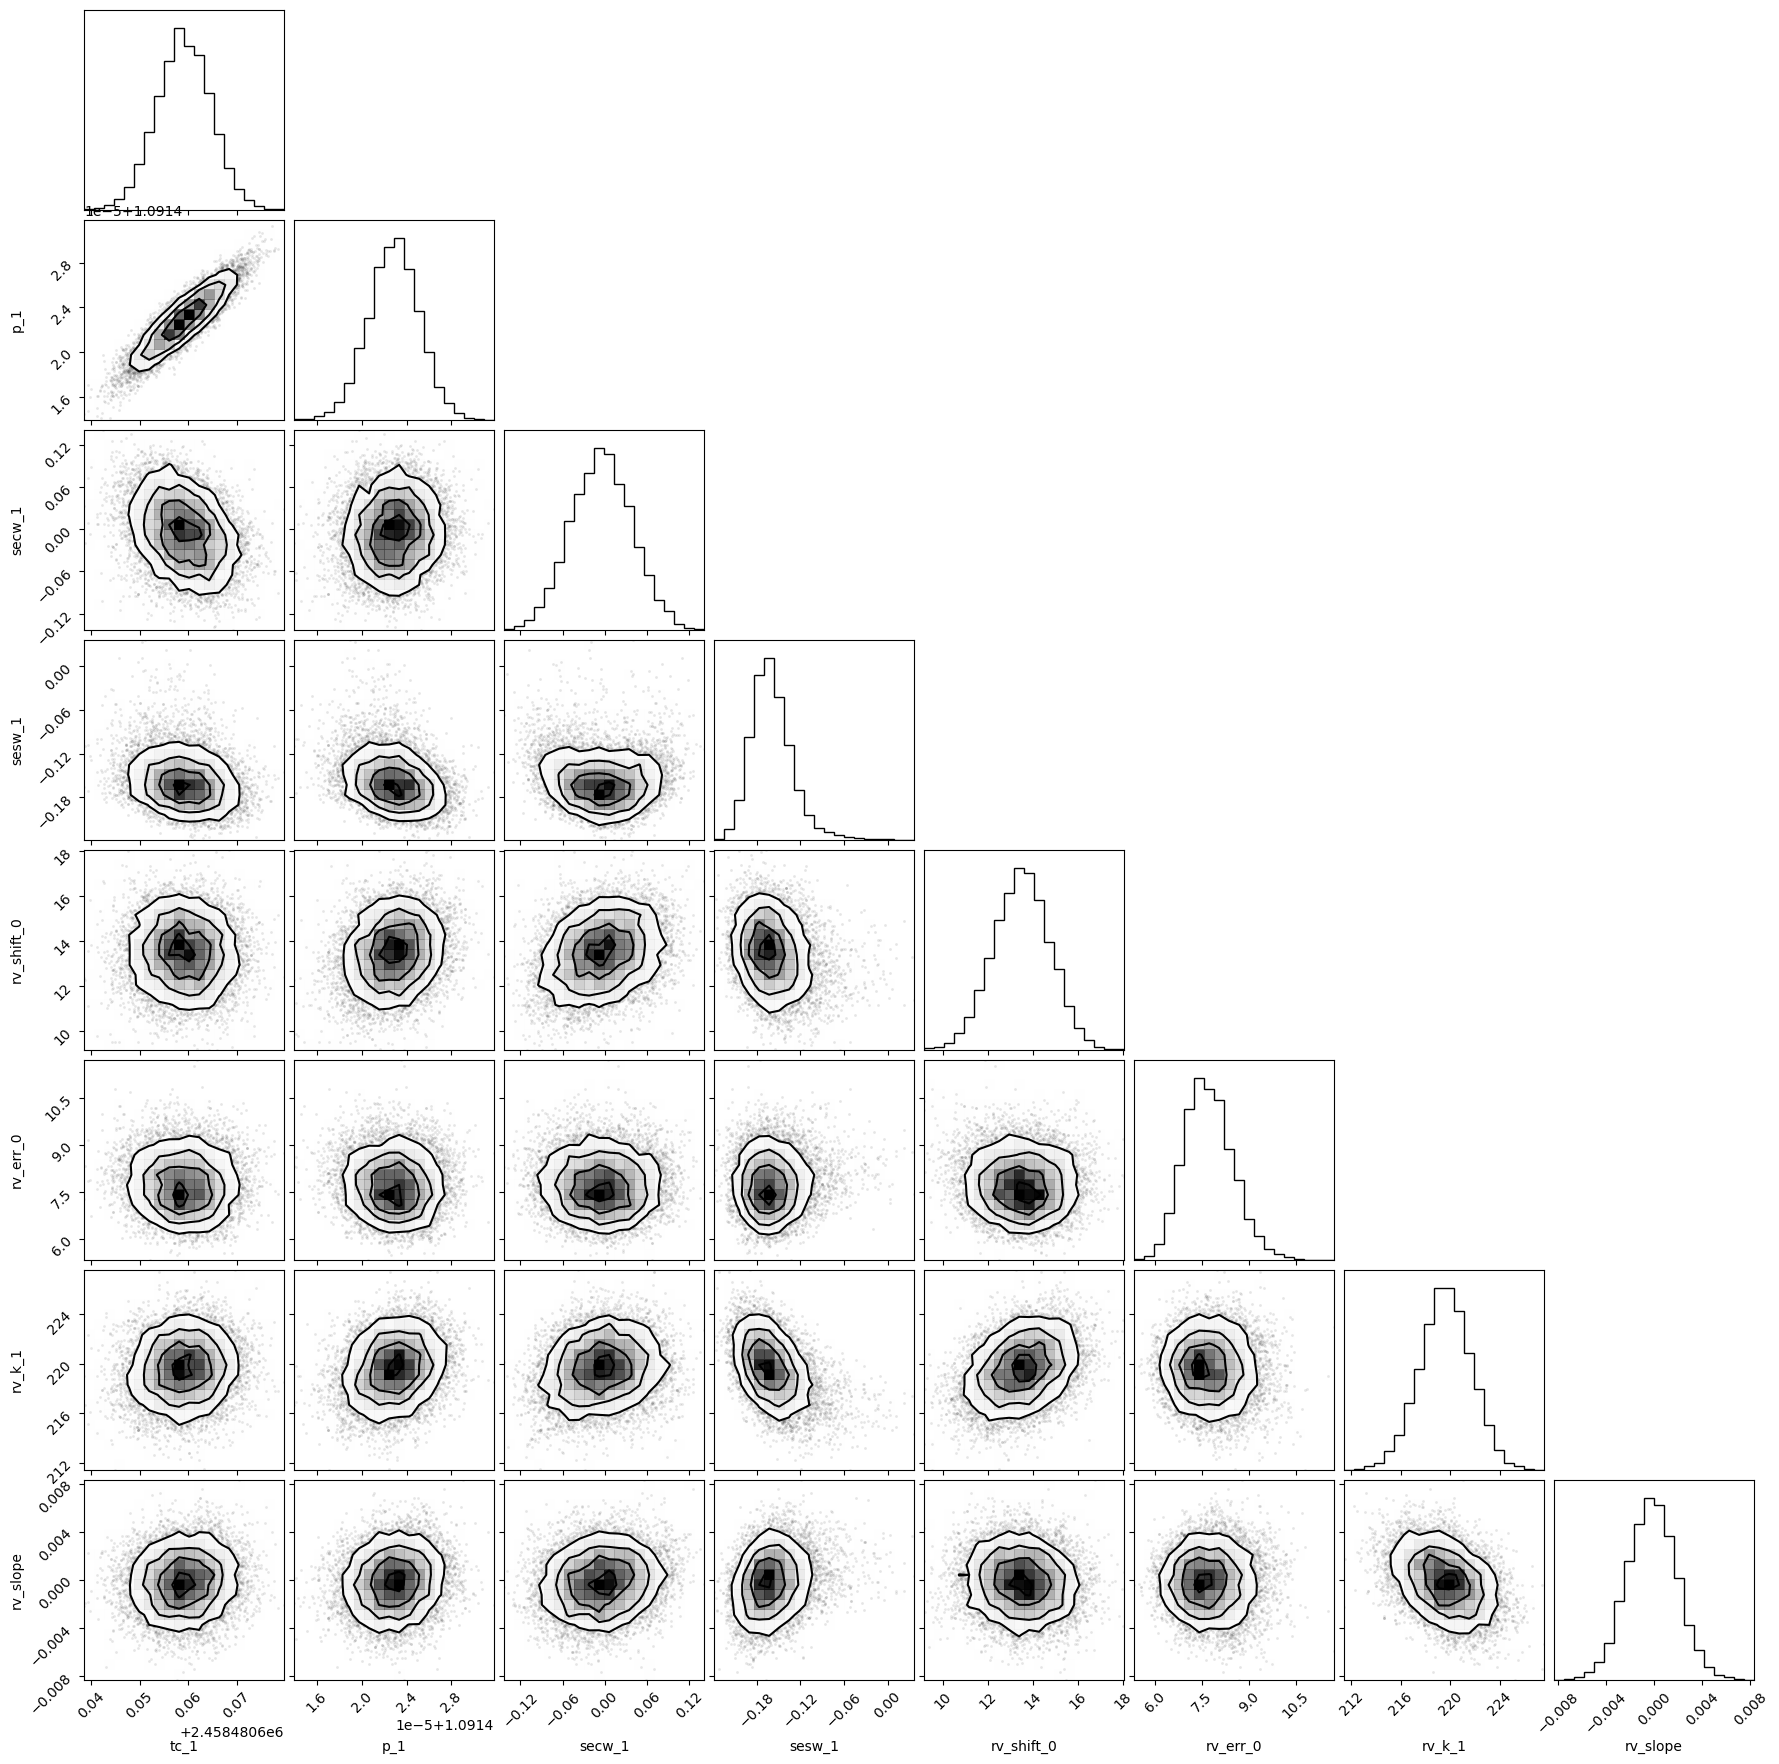

In [30]:
corner(df.values, labels=df.columns);

# The best scenario is that parameters behave as a gaussian
# In most cases we are not going to achieve that distribution. As we are parametrizing a lot of parameters it would be difficult


### <span style="color:darkblue">Questions and exercises</span>

1. What is the minimum mass ($m\sin i$) of WASP-12b assuming $e=0$? You can derive this from the RV semi-amplitude (K), orbital period (p), and the host star mass. 

-  <span style="color:darkgreen"> First, the host star mass must be konwn; from [Hebb et al. 2009](https://iopscience.iop.org/article/10.1088/0004-637X/693/2/1920/pdf): $M_{star} = 1.35 \pm 0.14 M_{\odot}$. The mass planet is also known, $M_{p} = 1.41 \pm 0.10 M_{J}$. As $M_{star} > M_{p}$, we are going to discard the planet mass in the following calculus.
    Moreover, eccentricity, $\varepsilon$ must be considered zero (as indicated). The **RV semi-amplitude, K**, can be derived for the given expression above:
    $$K = \left(\frac{2\pi G}{P}\right)^{1/3} \frac{M_\mathrm{p} \sin i}{(M_\star + M_\mathrm{p})^{2/3}} \frac{1}{(1-e^2)^{1/2}} \approx \left(\frac{2\pi G}{P}\right)^{1/3} \frac{M_\mathrm{p} \sin i}{(M_\star)^{2/3}} $$
    The **orbital period, p**, is calculated in the previous rows; it is $p=1.09145 \, dys$. The **RV semi-amplitude, K**, is obtained by the median of the values given by the posterior parameters determination, it is, $K=219.621$
$$
$$
    With this, the minimum mass ($m\sin i$) of WASP-12b can be determined:
    $$\mathbf{M_\mathrm{p} \sin i} =  K\, (M_\star)^{2/3}\left(\frac{P}{2\pi G}\right)^{1/3} = 2.58006 \cdot 10^{27} \, kg \mathbf{= 1.35936 \, \rm M_J}$$ 
    
<span style="color:darkgreen"> $\textit{[See calculations in the row below]}$

2. What would be the RV semi-amplitude of an Earth-mass planet orbiting WASP-12 with an orbital period of 365 days?

- <span style="color:darkgreen"> Assuming: $\varepsilon = 0, p=365 \, \rm dy$, $M_p \, sin(i) = M_{\bigoplus} = 5.972 \cdot 10^24 \, \rm kg $ and still considering $M_{star} = 1.35 \pm 0.14 M_{\odot}$, the **RV semi-amplitude** can be determined with the previous expression:
    $$\mathbf{K} \approx \left(\frac{2\pi G}{P}\right)^{1/3} \frac{M_\mathrm{p} \sin i}{(M_\star)^{2/3}} \mathbf{= 0.07324 \, \rm  m\cdot s^{-1}}$$
        $\textit{[See calculations in the row below]}$



3. We parameterise the model using ($\sqrt{e}\sin\omega$, $\sqrt{e}\cos\omega$) instead of ($e$, $\omega$). This parameterisation is more efficient to sample with an MCMC sampler, but means we need to take some extra steps to get the eccentricity and argument of periastron samples. Write below the equations you need to use to map the sampling parameters to $e$ and $\omega$?

- <span style="color:darkgreen"> If we define two parameters for each expression:
    $$sesw_1 = \sqrt{e} sin(w)$$
    $$secw_1 = \sqrt{e} cos(w)$$
    In order to obtain the expression for $\textit{e}$ and $\textit{w}$ is manipulating those two definitions of $\textit{$sesw_1$}$ and $\textit{$secw_1$}$:
    $$ \mathbf{(sesw_1)^2 + (secw_1)^2} = e \cdot sin^2(w) + e \cdot cos^2(w) = \mathbf{e}$$
    $$ \frac{sesw_1}{secw_1} = tan(w) \Rightarrow \mathbf{w = arctan(\frac{sesw_1}{secw_1})} $$
    
<span style="color:darkgreen"> In any case, we are working wth parameters which are dependant for each other, so the configuration of the model will be different for each variation. This scenario creates a multivalue space (i.e. a complex parameter space in the LH function), with a degeneracy problem. The **eccentricity** is hardly correlated with the **periastro**. The parametrization leads to a better parameter spacer, so it would be easier to optimize the problem in that way.
    
   
4. Derive $e$ and $\omega$ from the MCMC samples and plot their histograms.
 
    

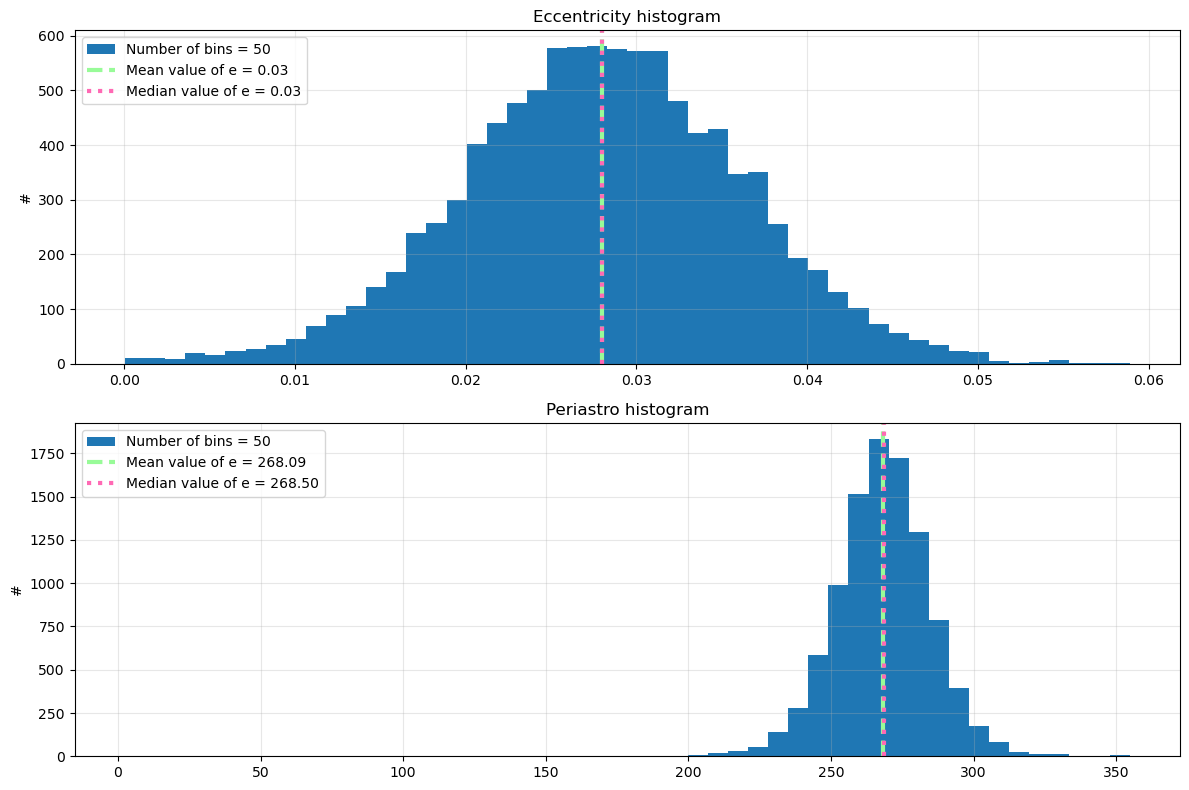

In [104]:
e = df.sesw_1**2 + df.secw_1**2
w = arctan2(df.sesw_1, df.secw_1)*180/pi

for i,j in enumerate(w):
    if j <0:
        w[i] = j +360
        
fig, axs = subplots(2,1, figsize=(12,8))
axs[0].hist(e, bins=50, label=('Number of bins = 50'))
axs[0].axvline(mean(e), c='palegreen', ls='dashed', lw=3, label=('Mean value of e = %.2f' % mean(e)))
axs[0].axvline(median(e), c='hotpink', ls='dotted', lw=3, label=('Median value of e = %.2f' % median(e)))
axs[0].set_title('Eccentricity histogram')

axs[1].hist(w, bins=50, label=('Number of bins = 50'))
axs[1].axvline(mean(w), c='palegreen', ls='dashed', lw=3, label=('Mean value of e = %.2f' % mean(w)))
axs[1].axvline(median(w), c='hotpink', ls='dotted', lw=3, label=('Median value of e = %.2f' % median(w)))
axs[1].set_title('Periastro histogram')

for i in range(2):
    axs[i].set_ylabel('#')
    axs[i].legend(loc='upper left')
    axs[i].grid(alpha=.3)
    
fig.tight_layout()
                   

In [95]:
# EXERCISE 1. DETERMINATION OF THE MINIMUM MASS OF THE PLANET
# Defining constants:
K = 219.621                 #m/s 
p = 1.09145 * 24 * 3600     #s  ;[from dys to s]
Mstar = 1.35*1.989e30       #kg ;[from MSun to kg] 
MJup = 1.898E27             #kg
G = 6.67430e-11             #Nm2/kg2

# Calculations
Mpsini = K*(p/(2*pi*G))**(1/3)*(Mstar)**(2/3)
Mpsini_MJ = Mpsini/MJup

print('The minimum mass of the planet is: %s MJup' %"{:e}".format(Mpsini_MJ))

The minimum mass of the planet is: 1.359359e+00 MJup


In [98]:
# EXERCISE 2. DETERMINATION OF THE RV SEMI-AMPLITUDE

Mearth = 5.972E24       #kg
p2 = 365 * 24 * 3600     #s  ;[from dys to s]

# Calculations
K2 = ((2*pi*G)/p2)**(1/3) * Mearth/(Mstar**(2/3))
print('The RV Semi-amplitude would be: %.5f [m/s]' %K2)

The RV Semi-amplitude would be: 0.07324 [m/s]


---

<center>&copy;2024 Hannu Parviainen</center>